In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, RSTDP_INH_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t2 import CorticalColumn, LayerConnection, ComplexStructure, load, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection, get_output_size_maxpool1d, BackwardConnections
from libs.network import MultiConnectionNetwork

In [2]:
seed = random.randint(0,9999999)
print(seed)

4534225


In [3]:
# seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

# Prepare Inputs

In [4]:
input_size_c1 = 200
input_size_c2 = 200
each_session = 40
session_number = 500
# layer23_involve_from = 500
gap_time = 20

time = session_number * each_session
spike_train_c1 = torch.zeros(time, input_size_c1).bool()
spike_train_c2 = torch.zeros(time, input_size_c2).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2


pattern_size = int(input_size_c1/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c1) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c1[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train_c1[idx * each_session: (idx + 1) * each_session, :int(input_size_c1/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train_c1[idx * each_session: (idx + 1) * each_session, int(input_size_c1/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls
    
pattern_size = int(input_size_c2/2)
for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size_c2) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train_c2[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train_c2[idx * each_session: (idx + 1) * each_session, :int(input_size_c2/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train_c2[idx * each_session: (idx + 1) * each_session, int(input_size_c2/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

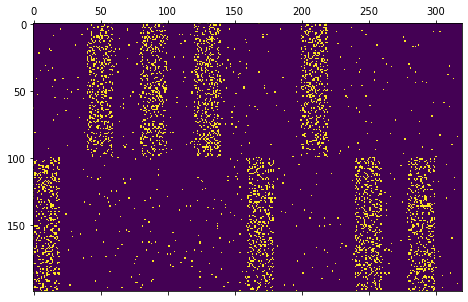

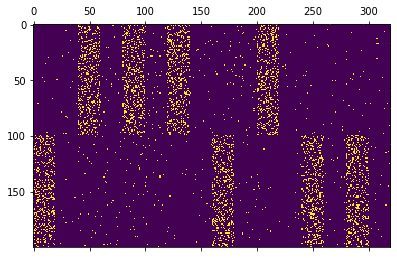

In [5]:
import matplotlib.pyplot as plt

plt.matshow(spike_train_c1.T[:, :8 * each_session])
plt.matshow(spike_train_c2.T[:, :8 * each_session])

# Load Models

In [6]:
c1_complex = load('models/c1.pt')
c2_complex = load('models/c2.pt')

In [7]:
c1 = c1_complex.submodules[0]
c2 = c2_complex.submodules[0]

In [8]:
c1.disable_learning()
c2.disable_learning()

# Create Model

In [9]:
connection_args = { # Between Layer
    'kernel_size': 5,
    'stride': 3,
    'weight': 16,
}
layer_args_l23 = {
    'exc_size': get_output_size_maxpool1d(100, 5, 3),
    'inh_con_args': { # Inside Layer
        'wmin': -3.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 1.0,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 15,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
    }
}
layer_args_l4 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -3.0,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.30,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 6,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
    }
}
input_to_cc_con_args = {
    'wmin': 0.,
    'wmax': 1.0,
    'nu': [0.03, 0.01],
#     'update_rule': PostPre,
    'probability': 0.50,
    
    'update_rule': MSTDPET_SEASONAL,
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
backward_args_kw = {
    'backward': True,
    'backward_exc_args': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_SEASONAL,
        'direct_voltage_manipulation': True,
        'wmin': 0.,
        'wmax': 0.95,
        'nu': [0.003, 0.007],
        'enable': True,

        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    },
    'backward_inh_args': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_INH_SEASONAL,
        'direct_voltage_manipulation': True,
        'wmin': -0.95,
        'wmax': 0,
        'nu': [0.007, 0.003],
        'enable': True,
        'behavior': 'inh',

        'windows_size': 5,
        'windows_std': 0.5,
        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    }
}
outter_backward_args = {
    'exc': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_SEASONAL,
        'direct_voltage_manipulation': True,
        'wmin': 0.,
        'wmax': 0.95,
        'nu': [0.003, 0.007],
        'enable': True,

        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    },
    'inh': {
        'potential_percent': torch.distributions.beta.Beta(3, 80),  # ("random", 0.1, 0.7),
        'connection_rate': 0.2,
        'before_computation_delay': 0,
        'update_rule': RSTDP_INH_SEASONAL,
        'direct_voltage_manipulation': True,
        'wmin': -0.95,
        'wmax': 0,
        'nu': [0.007, 0.003],
        'enable': True,
        'behavior': 'inh',

        'windows_size': 5,
        'windows_std': 0.5,
        'weight_decay': 0.00005,
        'tc_plus': 6,
        'tc_minus': 6, 
        'tc_e_trace': 6,
    }
}
connection_type = RandomConnection

In [10]:
c3 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name="c3", monitor=LAYER_23|LAYER_4, **backward_args_kw)

In [11]:
c1_c3_connection = LayerConnection(c1_complex, c3, connection_type, input_to_cc_con_args)
c2_c3_connection = LayerConnection(c2_complex, c3, connection_type, input_to_cc_con_args)
# TODO: add backwards

In [12]:
# Outter Backwards
c3_c1_backward_exc = LayerConnection(c3, c1, BackwardConnections, outter_backward_args['exc'])
c3_c2_backward_exc = LayerConnection(c3, c2, BackwardConnections, outter_backward_args['exc'])
c3_c1_backward_inh = LayerConnection(c3, c1, BackwardConnections, outter_backward_args['inh'])
c3_c2_backward_inh = LayerConnection(c3, c2, BackwardConnections, outter_backward_args['inh'])

In [13]:
model = ComplexStructure()
model.add_submodule(c1_complex)
model.add_submodule(c2_complex)
model.add_submodule(c3)
model.add_submodule(c1_c3_connection)
model.add_submodule(c2_c3_connection)

model.add_submodule(c3_c1_backward_exc)
model.add_submodule(c3_c2_backward_exc)
model.add_submodule(c3_c1_backward_inh)
model.add_submodule(c3_c2_backward_inh)

model.add_outpops_feedforward(c3.get_feedforward_output_pops())
model.add_inpops_backward(c3.get_backward_input_pops())

# Add to Network

In [14]:
network = MultiConnectionNetwork(dt=1.0)
model.add_to_network(network)

In [15]:
bl_monitors = []
bl_monitors_name = []
for a, b, con in c1_c3_connection.connections + c2_c3_connection.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

# Run Network

In [16]:
from tqdm import trange

rewards = []
changes = []
activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

#     if part == layer23_involve_from:
#         c3.l4.disable_learning()
#         input_to_c1_connection.disable_learning()
        
#         c3.l23.enable_learning()
#         c3.l4_l23.enable_learning()
        
        
    inp = {
        'input_c1': spike_train_c1[part*each_session:part*each_session+each_session, :],
        'input_c2': spike_train_c2[part*each_session:part*each_session+each_session, :],
    }
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c3.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c3.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c3.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
    exc2_act = c3.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
    activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]
    gap = abs(exc2_act - exc1_act) / layer_args_l23['exc_size']  #  In Range 0-1
    gap_check = abs(exc2_act - exc1_act) / layer_args_l23['exc_size'] > 0.3
    
    exc1_wins = exc1_act > exc2_act
    
    if pattern == exc1_wins and gap_check:
        reward = 1.0 + gap
    elif pattern == exc1_wins:
        reward = -0.5 + gap
    else:
        reward = -1 - gap
        
    rewards.append(reward)
    
    for conn in c1_c3_connection.connections + c2_c3_connection.connections:
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:12<00:00,  1.60parts/s]


In [17]:
rewards

[tensor(-2.5312),
 tensor(3.7188),
 tensor(4.8125),
 tensor(4.9688),
 tensor(-3.5625),
 tensor(4.),
 tensor(-2.5625),
 tensor(-4.1250),
 tensor(3.3438),
 tensor(5.),
 tensor(5.),
 tensor(4.0938),
 tensor(3.9062),
 tensor(4.5312),
 tensor(2.7500),
 tensor(4.9688),
 tensor(3.9375),
 tensor(4.9062),
 tensor(3.3750),
 tensor(4.1562),
 tensor(4.),
 tensor(5.3438),
 tensor(3.5000),
 tensor(5.0312),
 tensor(3.8438),
 tensor(3.8125),
 tensor(4.3125),
 tensor(3.8750),
 tensor(5.0312),
 tensor(4.9062),
 tensor(5.),
 tensor(5.3438),
 tensor(4.),
 tensor(4.2812),
 tensor(5.),
 tensor(4.9688),
 tensor(3.8438),
 tensor(5.),
 tensor(5.),
 tensor(5.),
 tensor(4.1562),
 tensor(3.9375),
 tensor(5.),
 tensor(5.),
 tensor(4.0312),
 tensor(4.0312),
 tensor(3.6562),
 tensor(4.9375),
 tensor(4.7812),
 tensor(4.),
 tensor(4.),
 tensor(4.1875),
 tensor(3.8438),
 tensor(4.1250),
 tensor(3.9688),
 tensor(4.2188),
 tensor(4.),
 tensor(4.2500),
 tensor(3.7188),
 tensor(5.),
 tensor(5.),
 tensor(5.0312),
 tensor(5.

# Analysis

In [18]:
time_show = time

In [19]:
spikes = {
    "C1 Output | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C1 Output | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "C2 Output | 1": c2.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "C2 Output | 2": c2.l23.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L4 | 1": c3.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c3.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c3.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c3.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Convergence

('c1_l23__exc1', 'c3_l4__exc1')
('c1_l23__exc1', 'c3_l4__exc2')
('c1_l23__exc2', 'c3_l4__exc1')
('c1_l23__exc2', 'c3_l4__exc2')
('c2_l23__exc1', 'c3_l4__exc1')
('c2_l23__exc1', 'c3_l4__exc2')
('c2_l23__exc2', 'c3_l4__exc1')
('c2_l23__exc2', 'c3_l4__exc2')


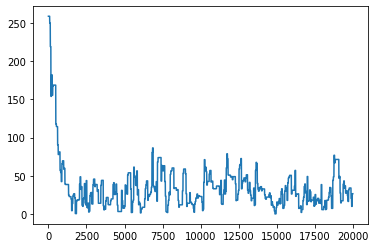

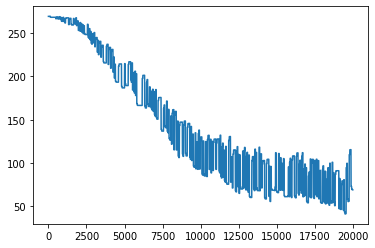

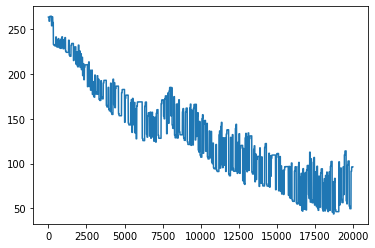

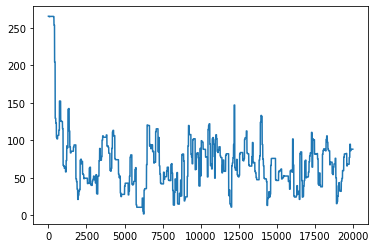

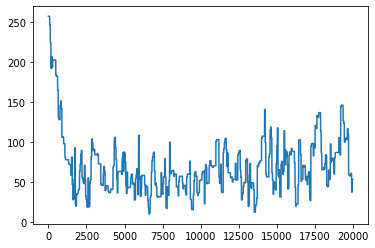

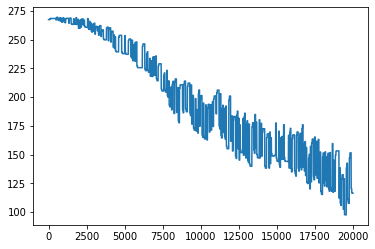

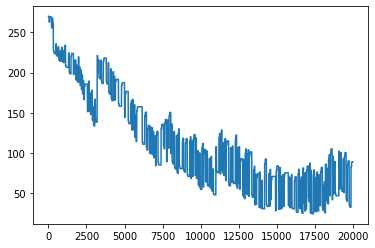

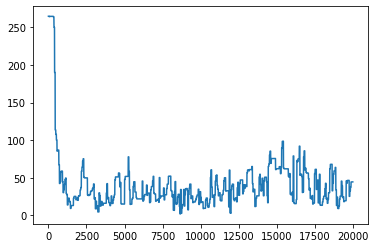

In [20]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

## Confusion

### Layer 4

In [21]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    258.30767822265625
L4 -- Excitatory 1 -- Pattern 2     :    0.0
L4 -- Excitatory 2 -- Pattern 1     :    1.9615384340286255
L4 -- Excitatory 2 -- Pattern 2     :    263.9583435058594


In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    265.2799987792969
L4 -- Excitatory 1 -- Pattern 2     :    0.0
L4 -- Excitatory 2 -- Pattern 1     :    1.600000023841858
L4 -- Excitatory 2 -- Pattern 2     :    255.1999969482422


In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    344.6976623535156
L4 -- Excitatory 1 -- Pattern 2     :    2.404958724975586
L4 -- Excitatory 2 -- Pattern 1     :    0.682170569896698
L4 -- Excitatory 2 -- Pattern 2     :    338.31817626953125


### Layer 2,3

In [24]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    90.15384674072266
L4 -- Excitatory 1 -- Pattern 2     :    0.0
L4 -- Excitatory 2 -- Pattern 1     :    0.07692307978868484
L4 -- Excitatory 2 -- Pattern 2     :    89.08333587646484


In [25]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    90.72000122070312
L23 -- Excitatory 1 -- Pattern 2     :    0.0
L23 -- Excitatory 2 -- Pattern 1     :    0.14000000059604645
L23 -- Excitatory 2 -- Pattern 2     :    86.12000274658203


In [26]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    116.9341049194336
L23 -- Excitatory 1 -- Pattern 2     :    1.2685950994491577
L23 -- Excitatory 2 -- Pattern 1     :    0.11240310221910477
L23 -- Excitatory 2 -- Pattern 2     :    114.611572265625


## Pattern Separation

In [27]:
c1_c3_connection.submodules

[]

In [28]:
for source, target, connection in c1_c3_connection.connections + c2_c3_connection.connections:
    print(f"{source}  --->   {target}   :   {connection.w.sum()}")

c1_l23__exc1  --->   c3_l4__exc1   :   2339.57861328125
c1_l23__exc1  --->   c3_l4__exc2   :   139.186279296875
c1_l23__exc2  --->   c3_l4__exc1   :   131.79310607910156
c1_l23__exc2  --->   c3_l4__exc2   :   1453.23193359375
c2_l23__exc1  --->   c3_l4__exc1   :   1970.0380859375
c2_l23__exc1  --->   c3_l4__exc2   :   240.64012145996094
c2_l23__exc2  --->   c3_l4__exc1   :   115.74703216552734
c2_l23__exc2  --->   c3_l4__exc2   :   1545.5797119140625


In [29]:
# for source, target, connection in c1.l4_l23.connections:
#     print(f"{source}   --->   {target}   :   {connection.w.sum()}")

## Activities

In [30]:
# x = 3
# plt.matshow(spike_train_c1.T[:, x * each_session:x * each_session + each_session])
# plt.matshow(spike_train_c2.T[:, x * each_session:x * each_session + each_session])

In [31]:
def show_spikes(time, spikes_name, fig_size=(10,14)):
    nos = len(spikes_name)
    x = time
    fig, axs = plt.subplots(1, nos, figsize=fig_size)
    for name, ax in zip(spikes_name, axs):
        ax.matshow(spikes[name][:, x * each_session:x * each_session + each_session])
        ax.set_title(name)
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')

In [32]:
x = session_number - 1

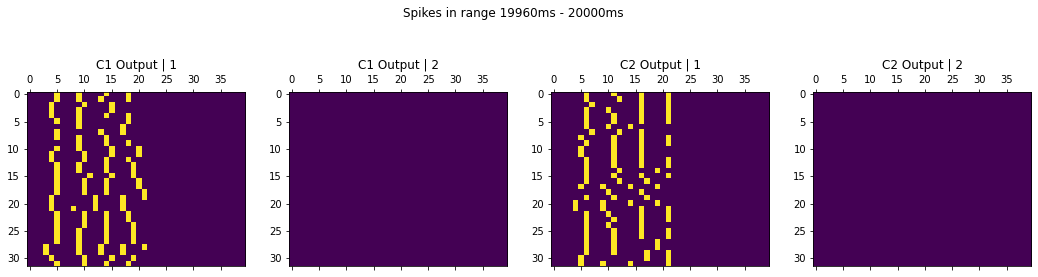

In [33]:
show_spikes(x, ["C1 Output | 1", "C1 Output | 2", "C2 Output | 1", "C2 Output | 2"], fig_size=(18,5))

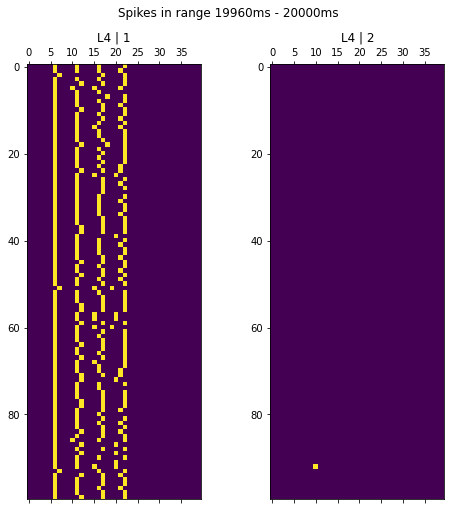

In [34]:
show_spikes(x, ["L4 | 1", "L4 | 2"], fig_size=(8,8))

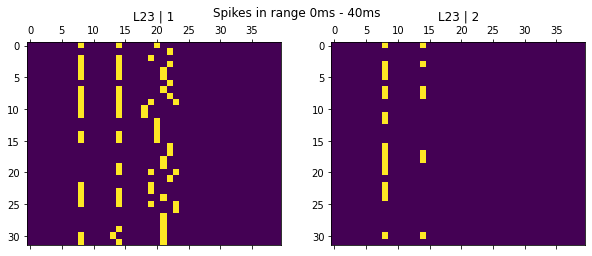

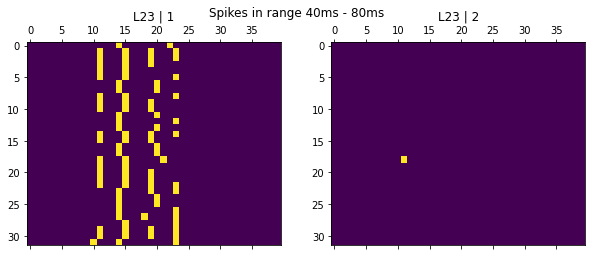

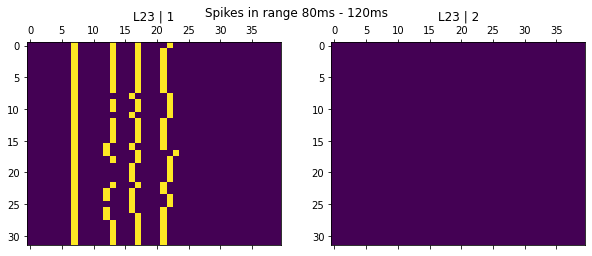

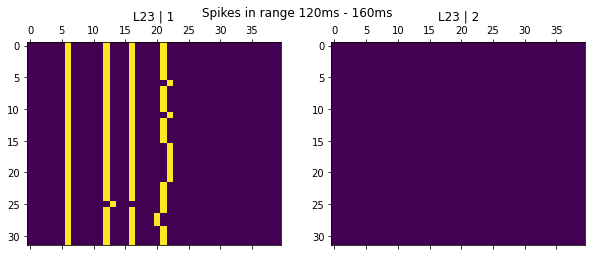

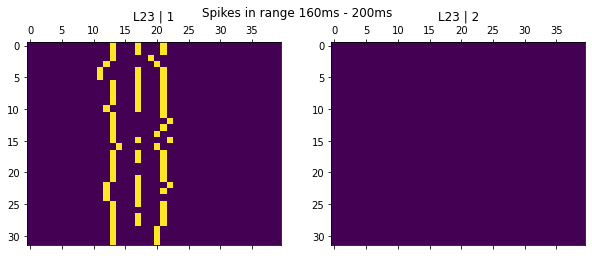

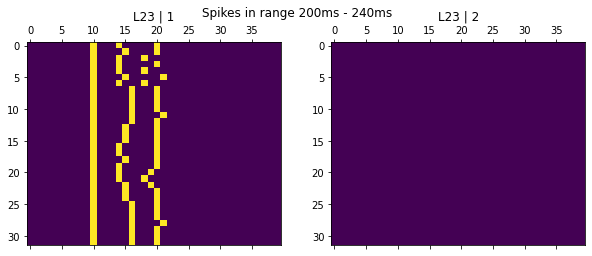

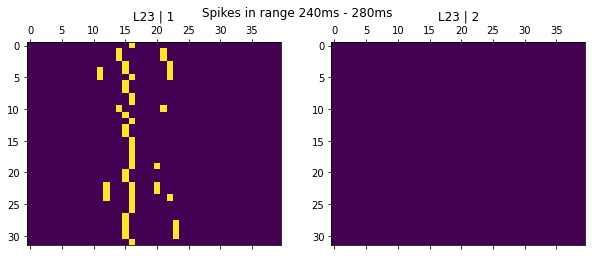

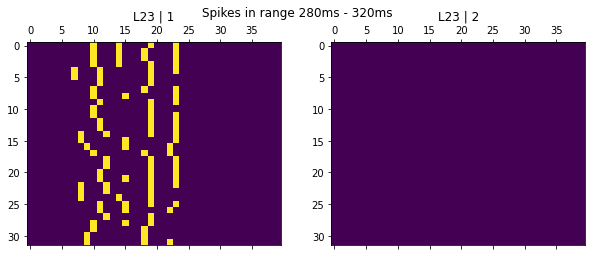

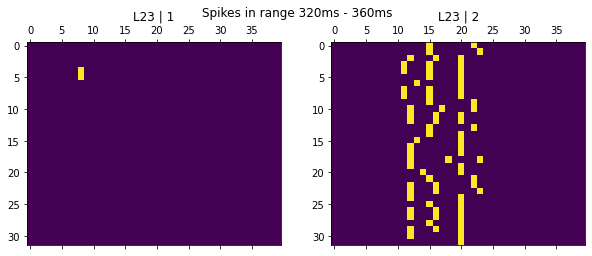

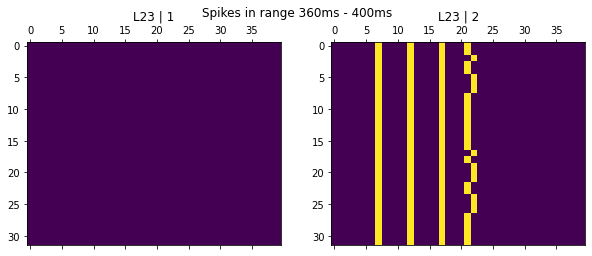

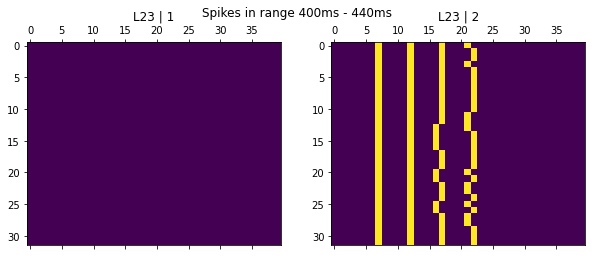

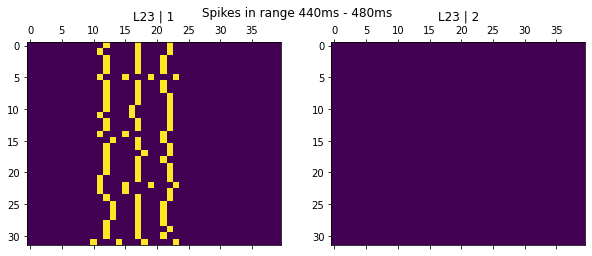

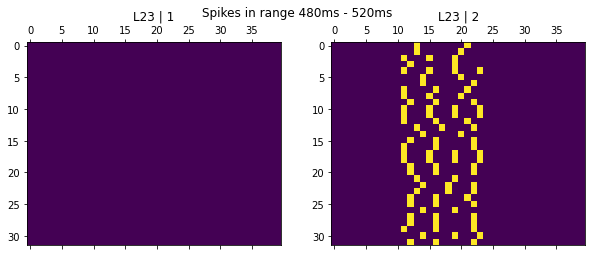

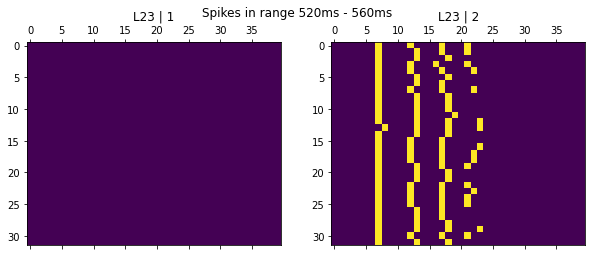

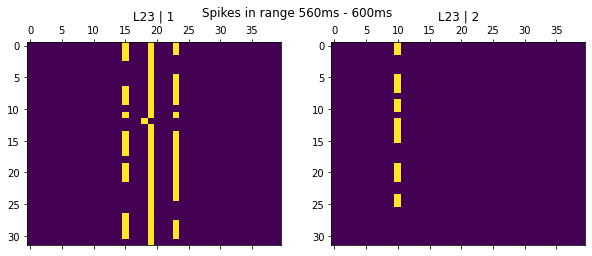

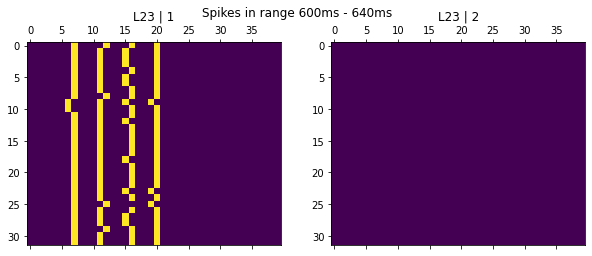

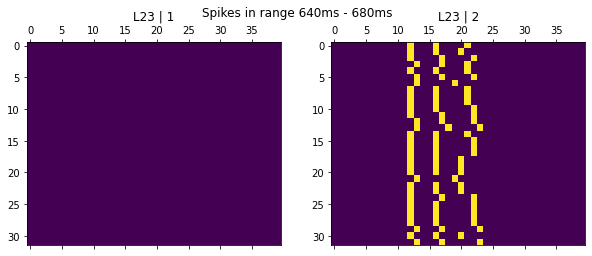

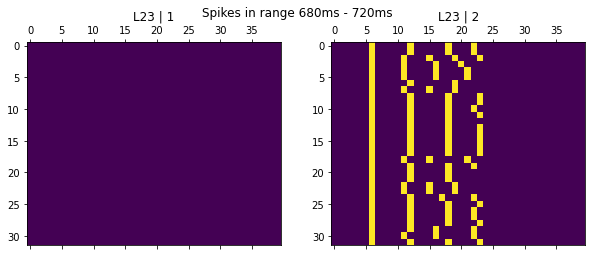

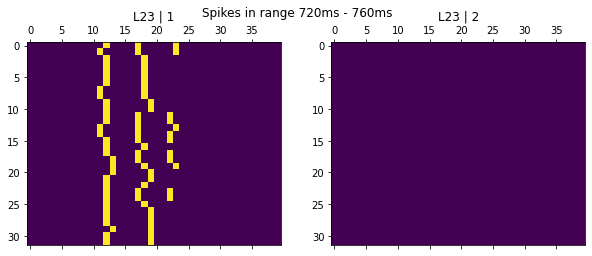

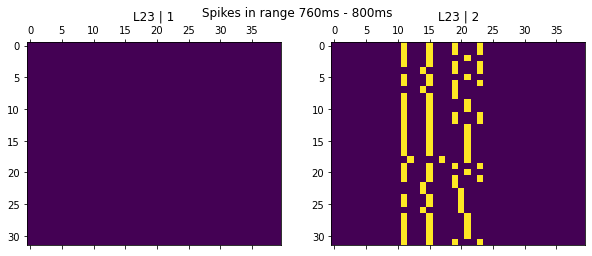

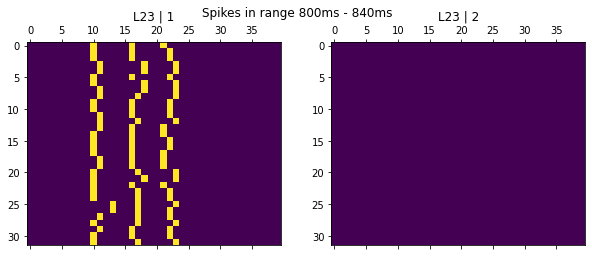

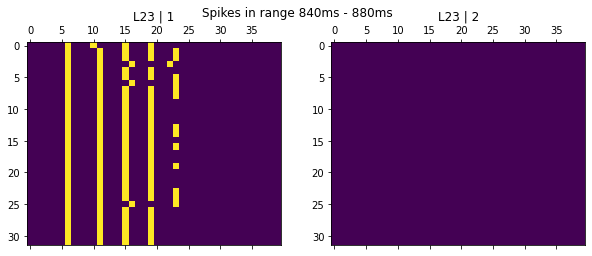

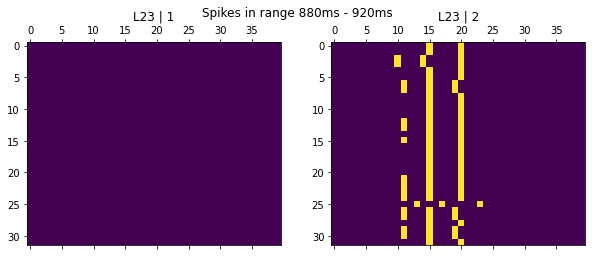

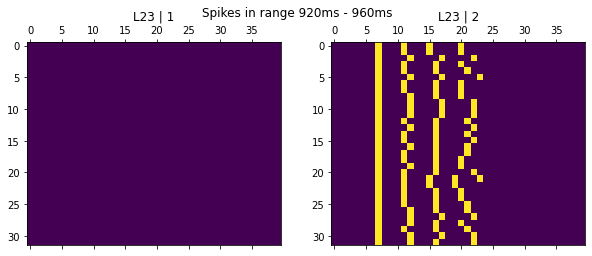

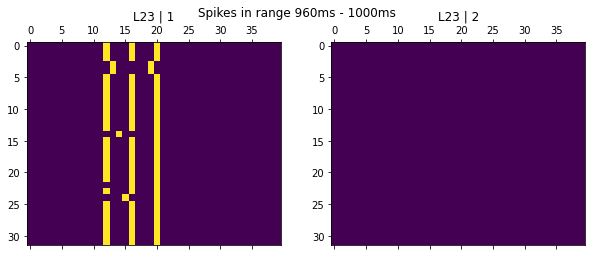

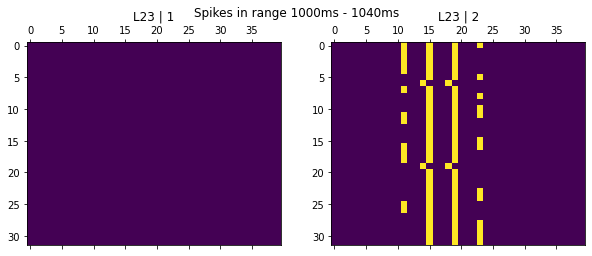

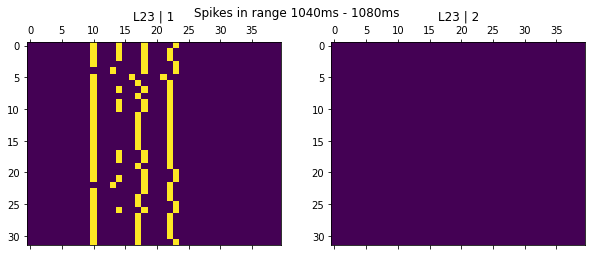

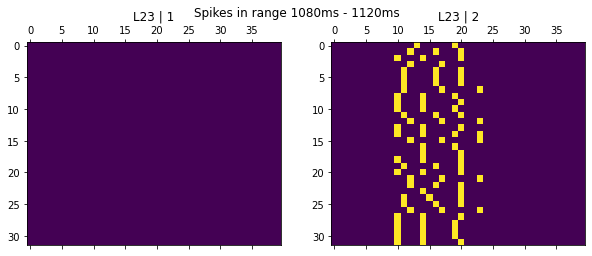

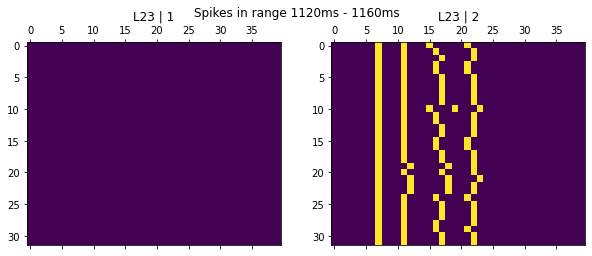

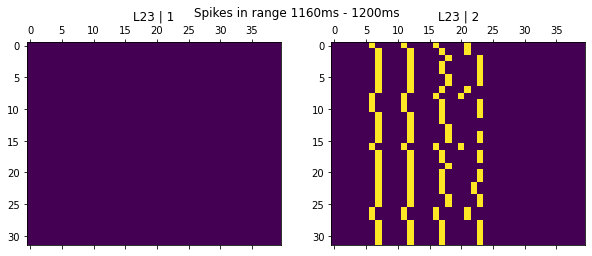

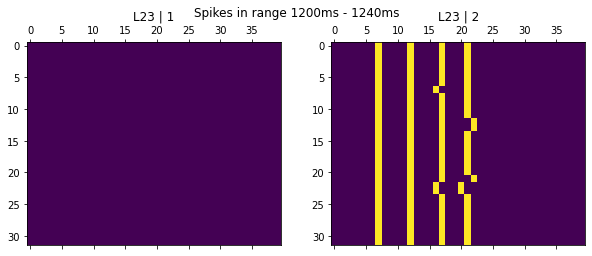

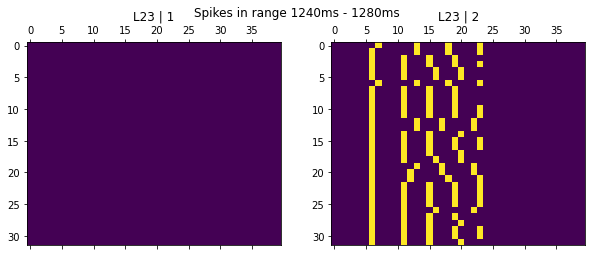

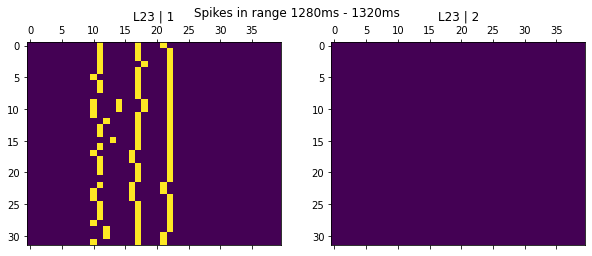

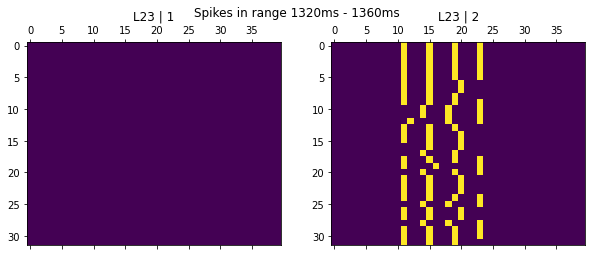

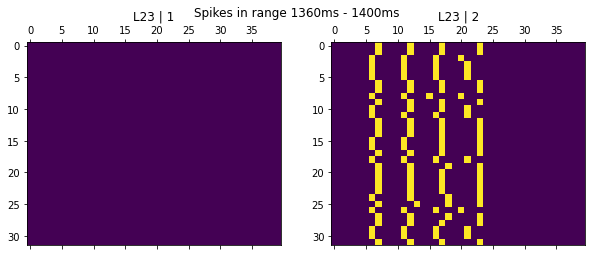

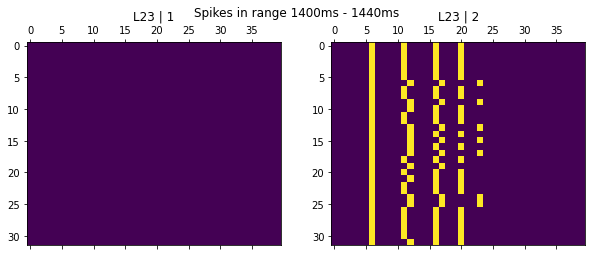

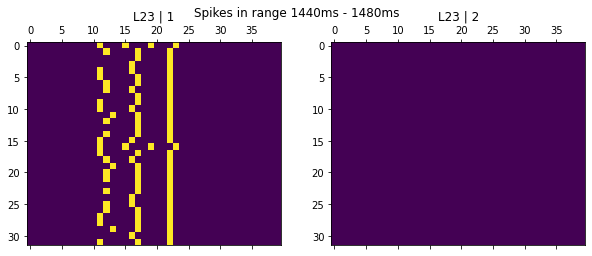

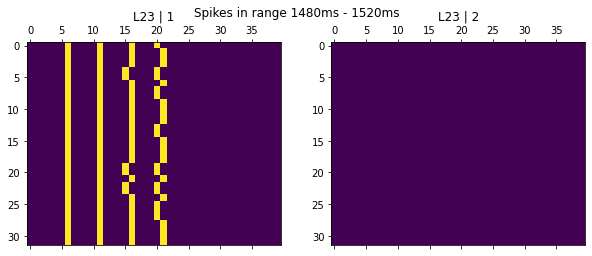

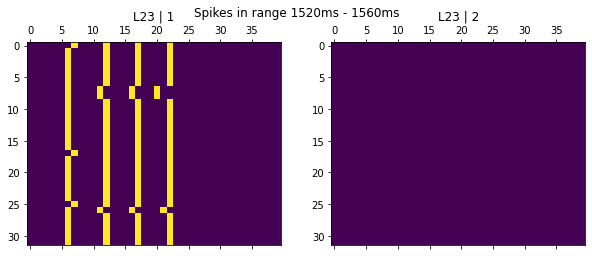

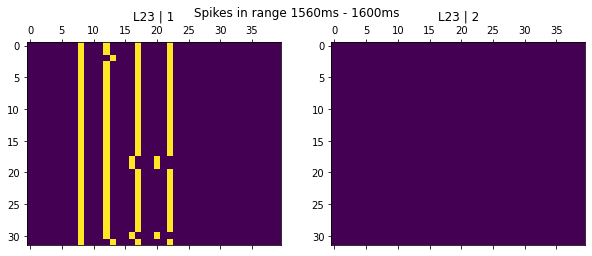

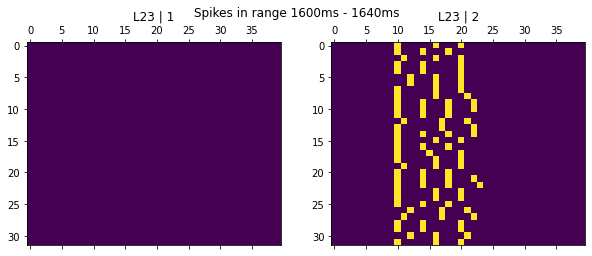

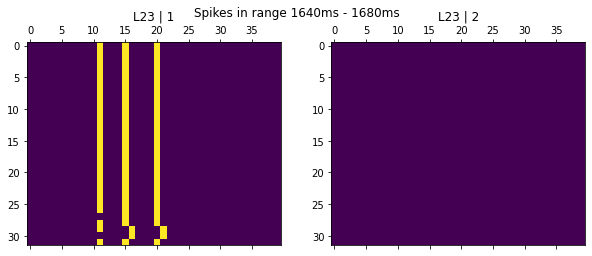

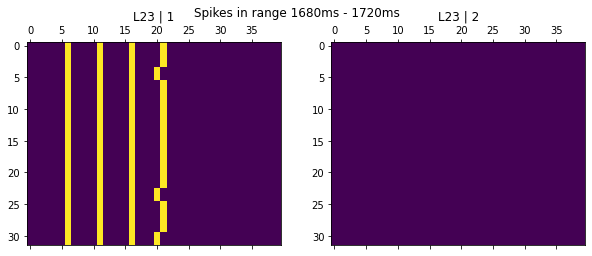

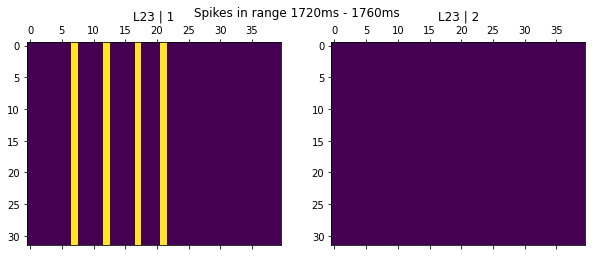

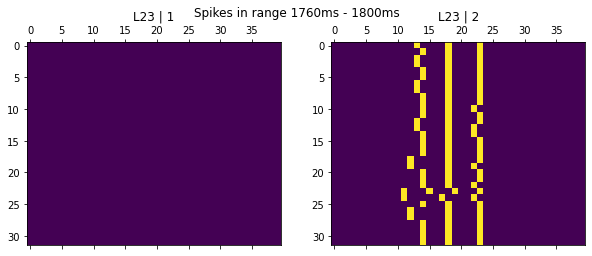

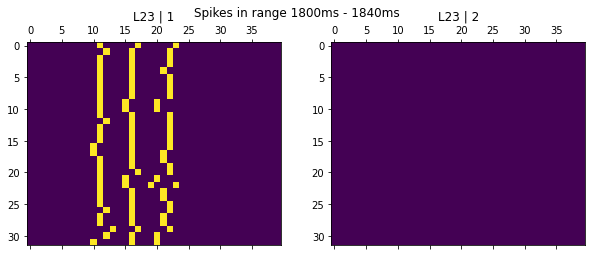

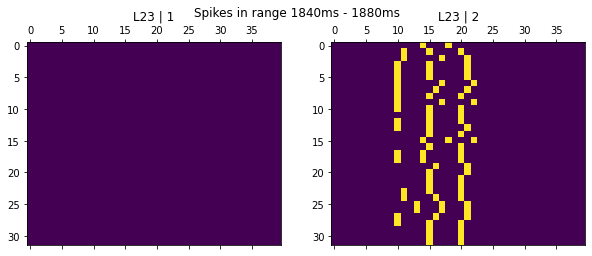

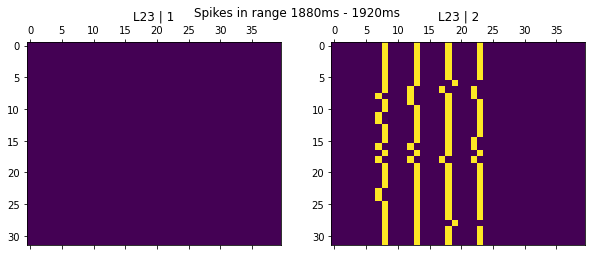

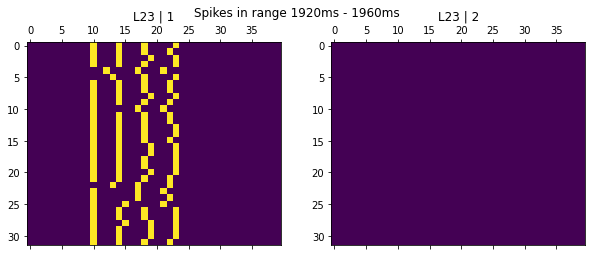

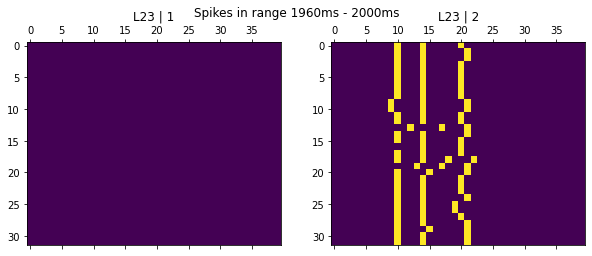

In [35]:
# print(session_class[x])
# plt.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
# plt.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])
for x in range(0, 50):
    show_spikes(x, ["L23 | 1", "L23 | 2"], fig_size=(10,4))

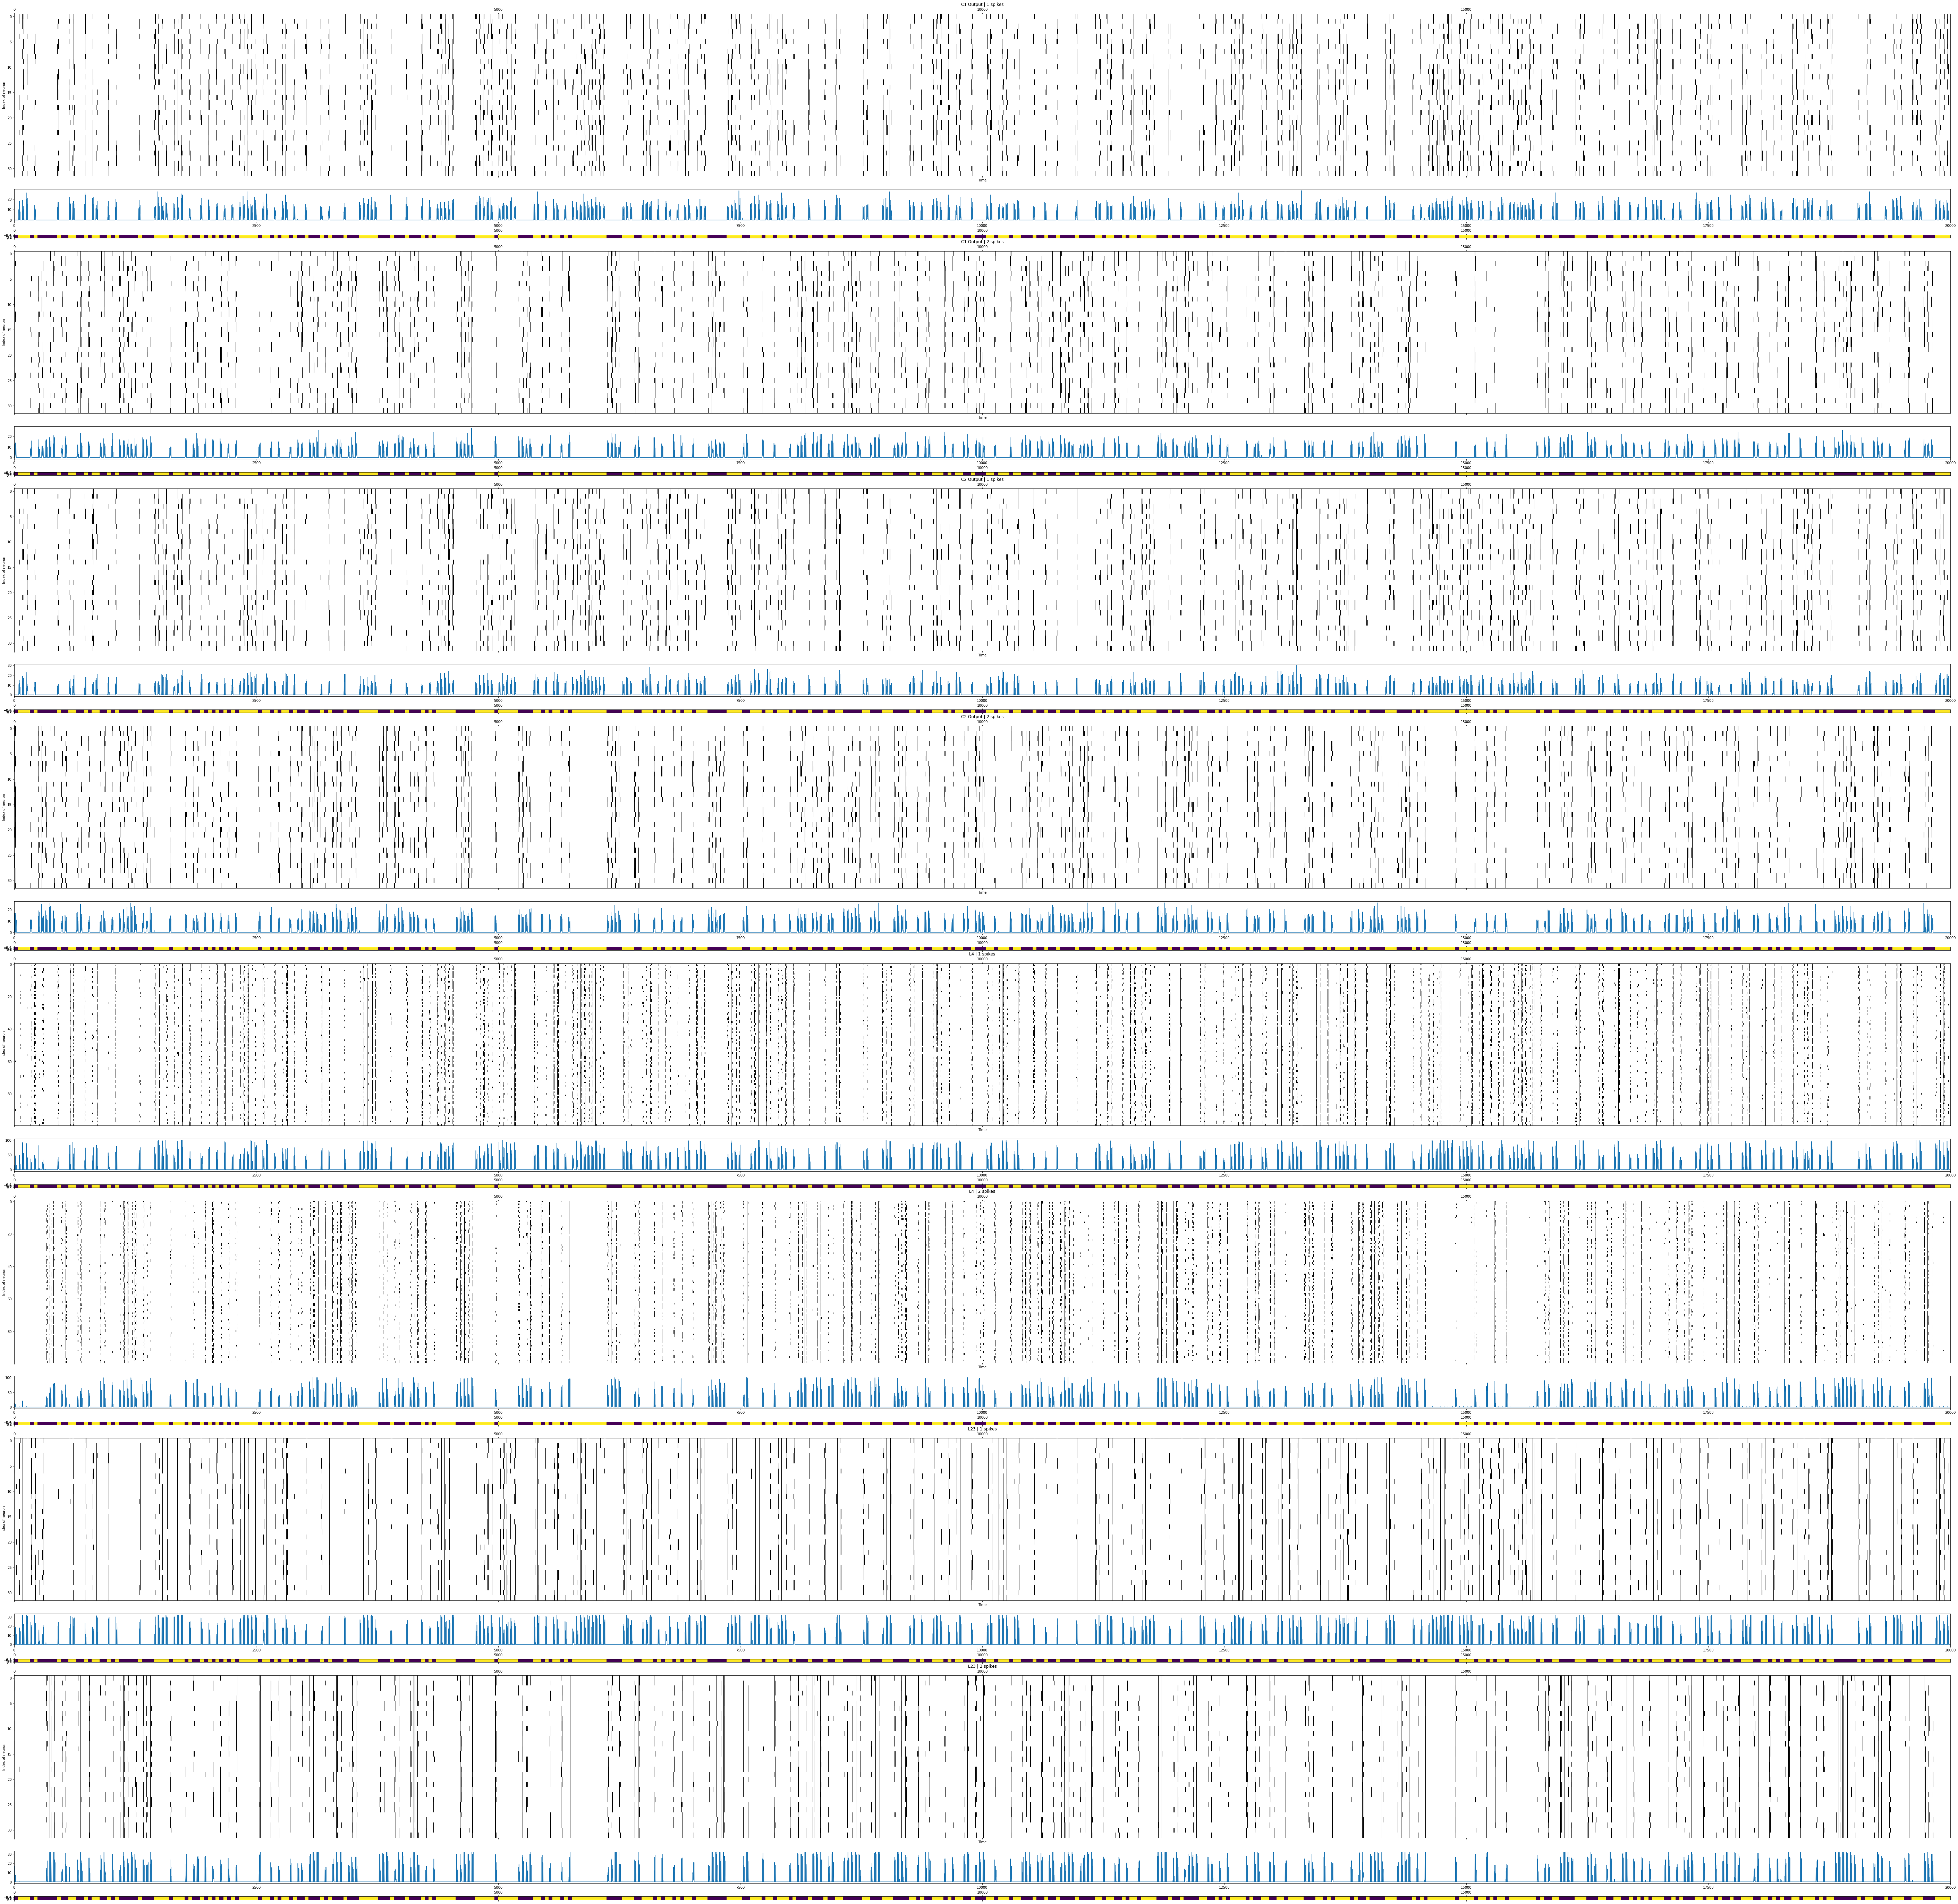

In [36]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')

### Weights inside one CC

In [37]:
for so,ta,c in c3.backward_exc_connection.get_connections():
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c3_l23__exc1 c3_l4__exc1 tensor(0.1902) tensor(0.9483) 


c3_l23__exc1 c3_l4__exc2 tensor(0.0479) tensor(0.2373) 


c3_l23__exc2 c3_l4__exc1 tensor(0.0477) tensor(0.2388) 


c3_l23__exc2 c3_l4__exc2 tensor(0.1855) tensor(0.9394) 




In [38]:
for so,ta,c in c1.backward_inh_connection.get_connections():
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c1_l23__exc1 c1_l4__exc1 tensor(-0.0518) tensor(-0.2599) 


c1_l23__exc1 c1_l4__exc2 tensor(-0.0018) tensor(-0.0095) 


c1_l23__exc2 c1_l4__exc1 tensor(-0.0021) tensor(-0.0099) 


c1_l23__exc2 c1_l4__exc2 tensor(-0.0516) tensor(-0.2523) 




### Weights of inter-CC backwards

In [39]:
for so,ta,c in c3_c1_backward_exc.get_connections():
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c3_l23__exc1 c1_l23__exc1 tensor(0.1905) tensor(0.9468) 


c3_l23__exc1 c1_l23__exc2 tensor(0.0521) tensor(0.2383) 


c3_l23__exc2 c1_l23__exc1 tensor(0.0520) tensor(0.2637) 


c3_l23__exc2 c1_l23__exc2 tensor(0.1890) tensor(0.9350) 




In [40]:
for so,ta,c in c3_c2_backward_exc.get_connections():
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c3_l23__exc1 c2_l23__exc1 tensor(0.1877) tensor(0.9468) 


c3_l23__exc1 c2_l23__exc2 tensor(0.0506) tensor(0.2687) 


c3_l23__exc2 c2_l23__exc1 tensor(0.0481) tensor(0.2278) 


c3_l23__exc2 c2_l23__exc2 tensor(0.1826) tensor(0.9397) 




In [41]:
for so,ta,c in c3_c1_backward_inh.get_connections():
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c3_l23__exc1 c1_l23__exc1 tensor(-0.1947) tensor(-0.9275) 


c3_l23__exc1 c1_l23__exc2 tensor(-0.0033) tensor(-0.0181) 


c3_l23__exc2 c1_l23__exc1 tensor(-0.0029) tensor(-0.0139) 


c3_l23__exc2 c1_l23__exc2 tensor(-0.1691) tensor(-0.7802) 




In [42]:
for so,ta,c in c3_c2_backward_inh.get_connections():
    t = c.w
    print(so, ta, t.mean(), t[t != 0].mean(),"\n\n")

c3_l23__exc1 c2_l23__exc1 tensor(-0.1599) tensor(-0.8442) 


c3_l23__exc1 c2_l23__exc2 tensor(-0.0037) tensor(-0.0184) 


c3_l23__exc2 c2_l23__exc1 tensor(-0.0026) tensor(-0.0129) 


c3_l23__exc2 c2_l23__exc2 tensor(-0.1947) tensor(-0.8939) 




In [43]:
c3_c1_backward_exc.get_connections()[0][2].w.sum()

tensor(195.0339)

# Save Model And Notebook

In [44]:
%%javascript
function custom_kernel_ready_handler() {
    require(["base/js/namespace"],function(Jupyter) {
        Jupyter.notebook.save_checkpoint();
    });
    IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
}

function handle_kernel_ready() {
    // Create a nb_name variable with the name of the notebook
     console.log('kernel_ready.Kernel: handle_kernel_ready() was triggered!');
     custom_kernel_ready_handler();

     Jupyter.notebook.events.one('kernel_ready.Kernel', () => {
         //this recursive behavior is esential for `restart` kernel
         handle_kernel_ready();
    });
}

Jupyter.notebook.events.one('kernel_ready.Kernel', () => {
     handle_kernel_ready();
});

handle_kernel_ready();

<IPython.core.display.Javascript object>

In [45]:
model.disable_learning()
model.save(f'models/c3.pt')

In [46]:
import os
command = os.popen(f"jupyter-nbconvert --to html ./{nb_name} --stdout > models/c3.html")